In [1]:
import nibabel as nib
import os
import albumentations as A
import numpy as np
import plotly
import plotly.graph_objects as go


In [2]:
def load_img(file_path):
        img = nib.load(file_path)
        data = img.get_fdata()
        # data = np.asarray(img.dataobj)
        return data

In [57]:
#https://www.kaggle.com/spacedoge/task1-segmentation-interactive-3d-eda
class ImageReader:
    def __init__(
        self, img_size:int,
        normalize:bool=False, single_class:bool=False
    ) -> None:
        pad_size = img_size
        self.resize = A.Compose(
            [
                A.PadIfNeeded(min_height=pad_size, min_width=pad_size, value=0),
                A.Resize(img_size, img_size)
            ]
        )
        self.normalize=normalize
        self.single_class=single_class
        
    def read_file(self, image_path:str, mask_path:str) -> dict:
        raw_image = load_img(image_path)
        raw_mask = load_img(mask_path)
        processed_frames, processed_masks = [], []
        for frame_idx in range(raw_image.shape[2]):
            frame = raw_image[:, :, frame_idx]
            mask = raw_mask[:, :, frame_idx]
            resized = self.resize(image=frame, mask=mask)
            processed_frames.append(resized['image'])
            processed_masks.append(
                1*(resized['mask'] > 0) if self.single_class else resized['mask']
            )
        scan_data = np.stack(processed_frames, 0)
        if self.normalize:
            if scan_data.max() > 0:
                scan_data = scan_data/scan_data.max()
            scan_data = scan_data.astype(np.float32)
        return {
            'scan': scan_data,
            'segmentation': np.stack(processed_masks, 0),
            'orig_shape': raw_image.shape
        }


In [70]:
def generate_3d_scatter(
    x:np.array, y:np.array, z:np.array, colors:np.array,
    size:int=3, opacity:float=0.2, scale:str='Teal',
    hover:str='skip', name:str='MRI'
) -> go.Scatter3d:
    return go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers', hoverinfo=hover,
        marker = dict(
            size=size, opacity=opacity,
            color=colors, colorscale=scale
        ),
        name=name
    )


class ImageViewer3d():
    def __init__(
        self, reader:ImageReader,plot_for:str,
        mri_downsample:int=10, mri_colorscale:str='Ice'
    ) -> None:
        self.reader = reader
        self.mri_downsample = mri_downsample
        self.mri_colorscale = mri_colorscale
        self.plot_for = plot_for # 'kidney' for Kidney plots
    def load_clean_mri(self, image:np.array, orig_dim:int) -> dict:
        shape_offset = image.shape[1]/orig_dim
        z, x, y = (image > 0).nonzero()
        x, y, z = x[::self.mri_downsample], y[::self.mri_downsample], z[::self.mri_downsample]
        colors = image[z, x, y]
        return dict(x=x/shape_offset, y=y/shape_offset, z=z, colors=colors)
    
    def load_tumor_segmentation(self, image:np.array, orig_dim:int) -> dict:
        tumors = {}
        shape_offset = image.shape[1]/orig_dim
        
        if self.plot_for == 'brain':
            sampling = {
                1: 1,
                2: 3, 4: 5
            }
        elif self.plot_for == 'kidney':
            sampling = {
                1: 1,
            }
        for class_idx in sampling:
            z, x, y = (image == class_idx).nonzero()
            x, y, z = x[::sampling[class_idx]], y[::sampling[class_idx]], z[::sampling[class_idx]]
            tumors[class_idx] = dict(
                x=x/shape_offset, y=y/shape_offset, z=z,
                colors=class_idx/4
            )
        return tumors
    
    def collect_patient_data(self, scan:dict) -> tuple:
        clean_mri = self.load_clean_mri(scan['scan'], scan['orig_shape'][0])
        tumors = self.load_tumor_segmentation(scan['segmentation'], scan['orig_shape'][0])
        markers_created = clean_mri['x'].shape[0] + sum(tumors[class_idx]['x'].shape[0] for class_idx in tumors)
        
        if self.plot_for == 'brain':
            return [
                generate_3d_scatter(
                    **clean_mri, scale=self.mri_colorscale, opacity=0.4,
                    hover='skip', name='Brain MRI'
                ),
                generate_3d_scatter(
                    **tumors[1], opacity=0.8,
                    hover='all', name='Necrotic tumor core'
                ),
                generate_3d_scatter(
                    **tumors[2], opacity=0.4,
                    hover='all', name='Peritumoral invaded tissue'
                ),
                generate_3d_scatter(
                    **tumors[4], opacity=0.4,
                    hover='all', name='GD-enhancing tumor'
                ),
            ], markers_created
        
        elif self.plot_for == 'kidney':
            return [
                generate_3d_scatter(
                    **clean_mri, scale=self.mri_colorscale, opacity=0.4,
                    hover='skip', name='Kidney'
                ),
                generate_3d_scatter(
                    **tumors[1], opacity=0.8,
                    hover='all', name='Tumor'
                )
            ],markers_created
    
    def get_3d_scan(self,image_path:str, mask_path:str) -> go.Figure:
        # scan = self.reader.load_patient_scan(patient_idx, scan_type)
        scan = self.reader.read_file(image_path, mask_path)
        data, num_markers = self.collect_patient_data(scan)
        fig = go.Figure(data=data)
        if self.plot_for == 'brain':
            fig.update_layout(
                title=f" BRAIN MRI VIZ",
                legend_title="Pixel class (click to enable/disable)",
                font=dict(
                    family="Courier New, monospace",
                    size=14,
                ),
                margin=dict(
                    l=0, r=0, b=0, t=30
                ),
                legend=dict(itemsizing='constant')
            )
        elif self.plot_for == 'kidney':
            fig.update_layout(
                title=f" KIDNEY MRI VIZ",
                legend_title="Pixel class (click to enable/disable)",
                font=dict(
                    family="Courier New, monospace",
                    size=14,
                ),
                margin=dict(
                    l=0, r=0, b=0, t=30
                ),
                legend=dict(itemsizing='constant')
            )
            
        return fig

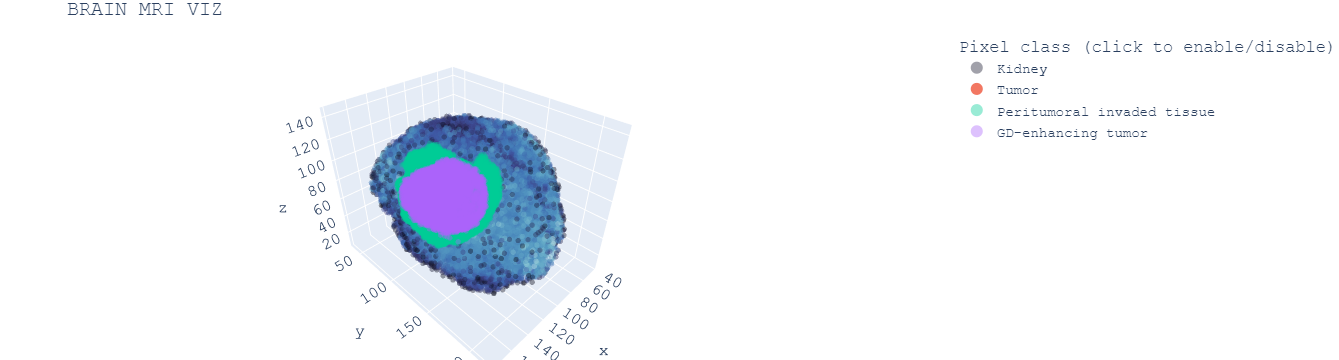

In [67]:
reader = ImageReader(160) #160 is the dimension of the image
viewer = ImageViewer3d(reader,'brain', mri_downsample=20)
fig = viewer.get_3d_scan('BraTS2021_00018/BraTS2021_00018_t1.nii.gz', #Replace this path with flair, t1ce or t2 to get that view
                       'BraTS2021_00018/BraTS2021_00018_seg.nii.gz')
plotly.offline.iplot(fig)

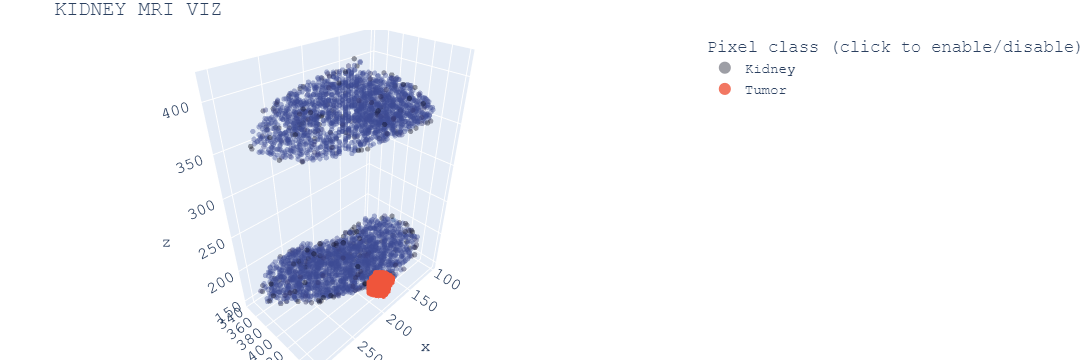

In [71]:
reader = ImageReader(160)
viewer = ImageViewer3d(reader,'kidney', mri_downsample=20)
fig = viewer.get_3d_scan('aggregated_OR_seg.nii.gz',
                       'tumor_instance-1_annotation-2.nii.gz')
plotly.offline.iplot(fig)